# Evaluation

In [2]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import time
from sklearn.utils import shuffle
from sklearn.preprocessing import StandardScaler    
import random
import torch.autograd as autograd
import torch.nn.functional as F

import torch.autograd as autograd
import pickle
from sklearn.decomposition import PCA
random_seed = 1245627304
torch.manual_seed(random_seed)
random.seed(random_seed)
DEVICE = torch.device('cpu')

In [3]:
params = pickle.load(open('wgan_best_parameters.pkl', 'rb'))
# print(params)
params_model = pickle.load(open('wgan_best_model_parameters.pkl', 'rb'))
# print(params_model)
params.update(params_model)
print(params)

{'lr_auto': 0.006435632456005054, 'epochs_autoen': 87, 'lr_wgan': 0.0028886418155533253, 'iters': 1031, 'critic_iters': 8, 'lambda': 6, 'emb_dim': 321, 'random_dim': 22}


In [4]:
batch_size = 128
lr_wgan = params.get('lr_wgan')
lr_auto = params.get('lr_auto')
seq_len = 5000 # initial space
emb_dim = params.get('emb_dim') # encoded space
random_dim = params.get('random_dim')  # latent space for the generator model
epochs_autoen = params.get('epochs_autoen') #epochs to train autoencoder
ITERS = params.get('iters') # iterations to train WGAN
CRITIC_ITERS = params.get('critic_iters')
LAMBDA = params.get('lambda') # penalty

# The distributions of fake and real parameters should be similar (or at least have intersection).

For evaluation we use 4 parameters: charge pulse amplitude, current pulse amplitude, tail slope and drift time

## 1. Preprocessing

In [34]:
real = pickle.load(open('/Users/nzaretski/Desktop/gerda/CNN_GAN_Ge/data/raw/data.pkl','rb'))
real = real.astype(float)

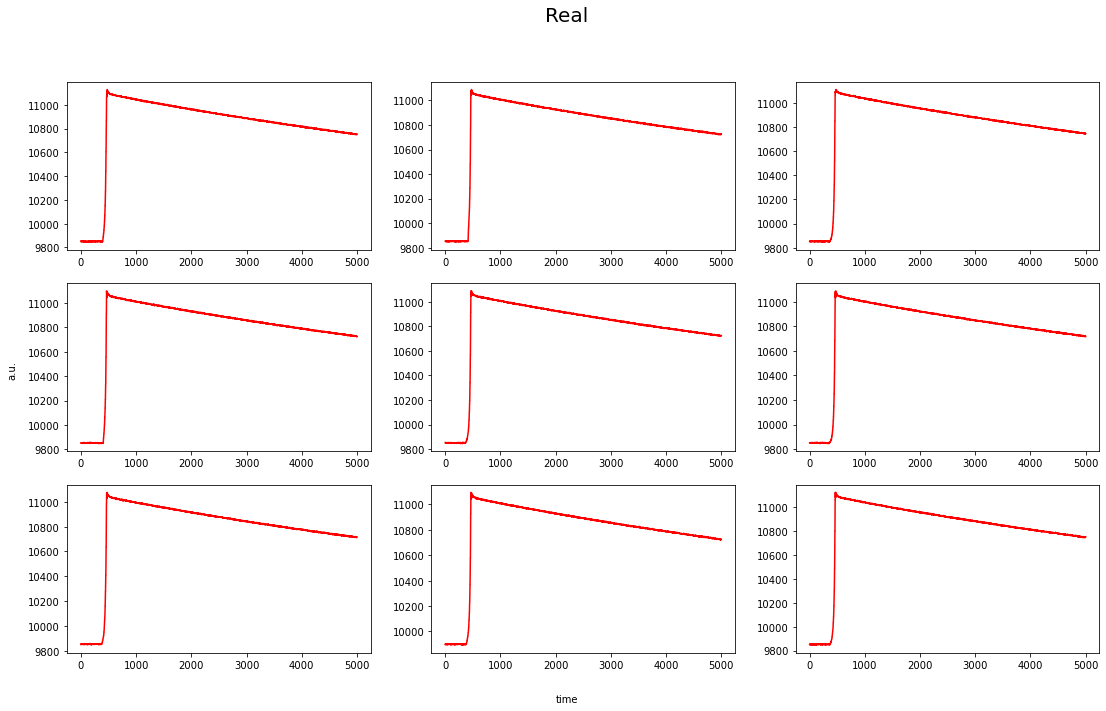

In [35]:
fig, axis = plt.subplots(3, 3, figsize=(18.5, 10.5))
for i in range(3):
    for j in range(3):
        axis[i, j].plot(real[random.randint(0, 1000)], color = 'red')
plt.suptitle('Real',fontsize=20)
fig.text(0.5, 0.06, 'time', ha='center')
fig.text(0.08, 0.5, 'a.u.', va='center', rotation='vertical')
fig.savefig('real.png')

### Fake data generation

In [37]:
class Decoder(nn.Module):
    def __init__(self, seq_len, emb_dim):
        super(Decoder, self).__init__()
        self.seq_len = seq_len
        self.emb_dim = emb_dim
        self.model = nn.Sequential(
            nn.ConvTranspose1d(self.emb_dim, self.seq_len // 8, 1, bias=False),
            nn.BatchNorm1d(self.seq_len // 8),
            nn.ReLU(True),

            nn.ConvTranspose1d(self.seq_len // 8, self.seq_len // 4, 1, bias=False),
            nn.BatchNorm1d(self.seq_len // 4),
            nn.ReLU(True),

            nn.ConvTranspose1d(self.seq_len // 4, self.seq_len // 2, 1, bias=False),
            nn.BatchNorm1d(self.seq_len // 2),
            nn.ReLU(True),

            nn.ConvTranspose1d(self.seq_len // 2, self.seq_len, 1, bias=False),
      )
    def forward(self, z):
        z = z.unsqueeze(-1)
        output = self.model(z)
        return output.squeeze(-1)
    
    
class Generator(nn.Module):
    def __init__(self, emb_dim, random_dim):
        super(Generator, self).__init__()
        self.emb_dim = emb_dim
        self.random_dim = random_dim
        self.model = nn.Sequential(
            nn.ConvTranspose1d(self.random_dim, self.emb_dim // 8, 1, bias=False),
            nn.BatchNorm1d(self.emb_dim // 8),
            nn.ReLU(True),

            nn.ConvTranspose1d(self.emb_dim // 8, self.emb_dim // 4, 1, bias=False),
            nn.BatchNorm1d(self.emb_dim // 4),
            nn.ReLU(True),

            nn.ConvTranspose1d(self.emb_dim // 4, self.emb_dim // 2, 1, bias=False),
            nn.BatchNorm1d(self.emb_dim // 2),
            nn.ReLU(True),

            nn.ConvTranspose1d(self.emb_dim // 2, self.emb_dim, 1, bias=False),
      )
    def forward(self, z):
        z = z.unsqueeze(-1)
        output = self.model(z)
        return output.squeeze(-1)

In [38]:
G = Generator(emb_dim, random_dim)
D = Decoder(seq_len, emb_dim)
G.load_state_dict(torch.load( "wgan_auto.pth"))
D.load_state_dict(torch.load( "wgan_auto_decoder.pth"))

<All keys matched successfully>

In [39]:
noise = torch.randn(2000, random_dim)

In [40]:
# Decoding and inverse tranformation
scaler = StandardScaler()
scaler = pickle.load(open('scaler.pkl','rb'))

fake = D(G(noise).detach()).detach()
fake = scaler.inverse_transform(fake)

Text(0, 0.5, 'a.u.')

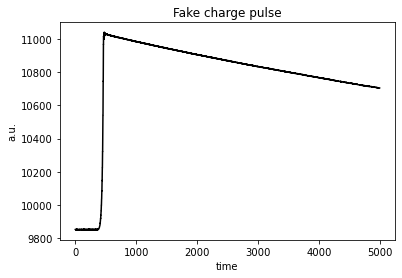

In [41]:
plt.plot(fake[0], color = 'black')
plt.title('Fake charge pulse')
plt.xlabel('time')
plt.ylabel('a.u.')

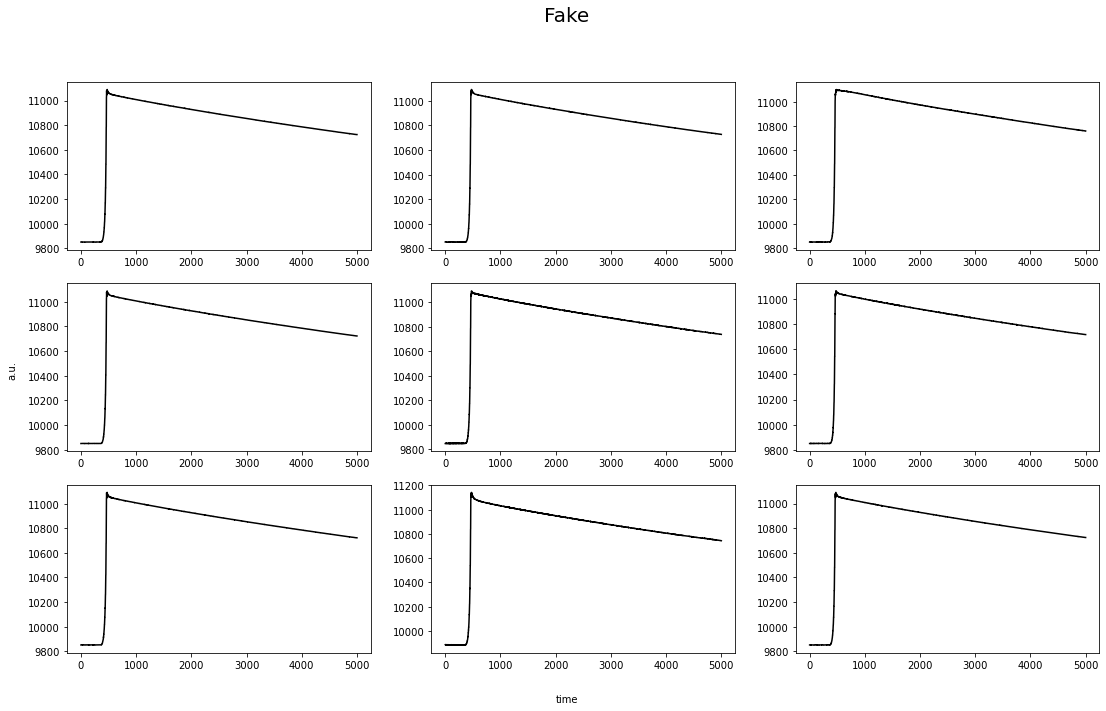

In [42]:
fig, axis = plt.subplots(3, 3, figsize=(18.5, 10.5))

#fig.set_size_inches(18.5, 10.5)
for i in range(3):
    for j in range(3):
        axis[i, j].plot(fake[random.randint(0, 1000)], color = 'black')
plt.suptitle('Fake',fontsize=20)
fig.text(0.5, 0.06, 'time', ha='center')
fig.text(0.08, 0.5, 'a.u.', va='center', rotation='vertical')
fig.savefig('real.png')

## Energy

In [43]:
max_real = np.max(real, axis = 1) - np.min(real, axis = 1)

In [44]:
max_fake = np.max(fake, axis = 1) - np.min(fake, axis = 1)

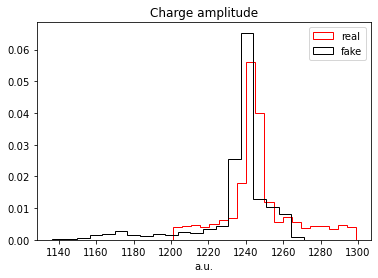

In [45]:
a1, _, _ = plt.hist(max_real, bins = 20, density = True, label = 'real',histtype = 'step', color = 'red')
a2, _, _ = plt.hist(max_fake, bins = 20, density = True, label = 'fake',histtype = 'step', color = 'black')

plt.legend()
plt.title('Charge amplitude')
plt.xlabel('a.u.')
plt.show()

## Current

In [46]:
real_c = np.diff(real, axis=1)

max_real_c = np.max(real_c, axis = 1) - np.min(real_c, axis = 1)

138.0

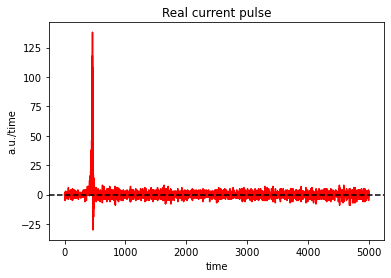

In [47]:
plt.plot(real_c[0], color='red')
plt.title('Real current pulse')
plt.xlabel('time')
plt.ylabel('a.u./time')
plt.axhline(real_c[0][1866], color = 'black', linestyle = '--')
real_c[0].max()

In [48]:
fake_c = np.diff(fake, axis=1)

max_fake_c = np.max(fake_c, axis = 1) - np.min(fake_c, axis = 1)

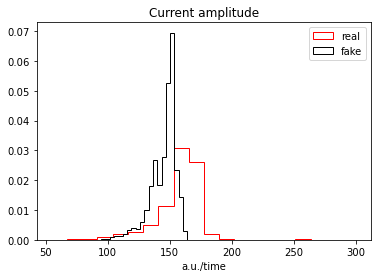

In [49]:
fig = plt.figure()
a1, _, _ = plt.hist(max_real_c, bins = 20,  label = 'real', density = True, histtype = 'step', color = 'red')
a2, _, _ = plt.hist(max_fake_c, bins = 20,  label = 'fake', density = True, histtype = 'step', color = 'black')

plt.legend()
plt.title('Current amplitude')
plt.xlabel('a.u./time')
plt.show()

## Tail slope

In [50]:
# The least point of the pulse is 0
real = real - np.min(real, axis=1).reshape(real.shape[0], 1)
fake = fake - np.min(fake, axis=1).reshape(fake.shape[0], 1)

In [51]:
def slope(mas):
    slopes = []
    for i in range(mas.shape[0]):
        m = max(mas[i])
        idx = list(mas[i]).index(m) #index of a max element
        s = 0
        for j in range(idx - 50, idx - 20):
            s += mas[i][j]
        avg1 = s / 30 #1 y-coordinate
        s = 0
        for j in range(idx + 1000, idx + 2000):
            s += mas[i][j]
        avg2 = s / 1000 #2 y-coordinate
        x = (idx + 1500) - (idx - 35)
        y = abs(avg2 - avg1)
        slopes.append(x / y)
    return np.array(slopes)

In [52]:
sl_r = slope(real)
sl_f = slope(fake)

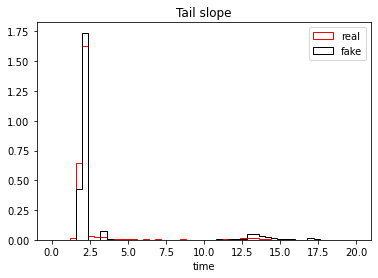

In [53]:
fig = plt.figure()
a1, _, _ = plt.hist(sl_r, bins = 50, range=[0, 20], density = True, label = 'real',histtype = 'step', color = 'red')
a2, _, _ = plt.hist(sl_f, bins = 50, range=[0, 20], density = True, label = 'fake',histtype = 'step', color = 'black')

plt.title('Tail slope')
plt.xlabel('time')
plt.legend()
plt.show()
fig.savefig('slope.png')

## Drift time
Difference between the time of 90% of the amplitude and the time of 10% of the amplitude

In [54]:
# Normalization
real = (real - np.min(real, axis=1).reshape(real.shape[0], 1)) / (np.max(real, axis=1) - np.min(real, axis=1)).reshape(real.shape[0], 1)
fake = (fake - np.min(fake, axis=1).reshape(fake.shape[0], 1)) / (np.max(fake, axis=1) - np.min(fake, axis=1)).reshape(fake.shape[0], 1)

In [55]:
def drift(mas):
    drifttimes = []
    for j in range(mas.shape[0]):
        m = max(mas[j])
        idx = list(mas[j]).index(m) #index of a max element
        for i in range(idx):
            if (mas[j][i] - 0.9*m) <= 0.01:
                k90 = i
            if (mas[j][i] - 0.1*m) <= 0.01:
                k10 = i
        drifttimes.append(k90 - k10)
    drifttimes = np.array(drifttimes)
    return drifttimes

In [56]:
rr = drift(real)
rf = drift(fake)

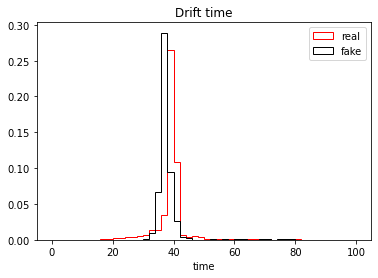

In [57]:
fig = plt.figure()
a1, _, _ = plt.hist(rr, bins = 50, range = [0, 100], density = True,  label = 'real',histtype = 'step', color = 'red')
a2, _, _ = plt.hist(rf, bins = 50, range = [0, 100], density = True,  label = 'fake',histtype = 'step', color = 'black')

plt.legend()
plt.title('Drift time')
plt.xlabel('time')
plt.show()
fig.savefig('drifttime.png')